# NeSy4PPM: Suffix prediction Tutorial
This notebook demonstrates how to use the NeSy4PPM framework for suffix prediction, specifically focused on activity and resource or activity-only prediction using neural architectures like LSTM and Transformer models. NeSy4PPM combines neural learning with symbolic background knowledge (BK) to produce accurate and compliant predictions under various conditions, including concept drift.

This notebook walks through the entire NeSy4PPM pipeline, including:

    1. Data preprocessing
    2. Training
    3. Prediction
    4. Evaluation

# 1 Data preprocessing
The __Data preprocessing__ is responsible for loading and transforming event log into neural-compatible inputs. This phase involves:

   - `Data loading`, which involves reading the event log from the input file,
   - `Prefixes extraction`,which refers to extracting prefixes (i.e., partial trace executions) from the training log.
   - `Prefixes encoding`,which handles the conversion of input prefixes and their corresponding labels into numerical representations suitable for neural models.

## 1.1 Data loading
The first step in the __data preprocessing__ pipeline is to load the event log (in a .xes, .csv or .xes.gz files) using the `LogData` class. The input of this step can be:
- A __single event log__, which will be automatically split into training and test sets based on the chronological order of case start timestamps and a defined train ratio.
- A pair of __separate training and test logs__.

### A. Single event log:

In [2]:
from pathlib import Path
from NeSy4PPM.Data_preprocessing import log_utils

log_path = Path.cwd().parent/'data'/'input'/'logs'
log_name = "helpdesk.xes"
train_ratio = 0.8
case_name_key = 'case:concept:name'
act_name_key = 'concept:name'
res_name_key = 'org:resource'
timestamp_key = 'time:timestamp'

log_data = log_utils.LogData(log_path=log_path,log_name=log_name,train_ratio=train_ratio,
                             case_name_key=case_name_key,act_name_key=act_name_key,
                             res_name_key=res_name_key,timestamp_key=timestamp_key)
print(f"Loaded log: {log_data.log_name}")
print(f"Trace max size: {log_data.max_len}")

parsing log, completed traces :: 100%|██████████| 4580/4580 [00:01<00:00, 2715.77it/s]


Loaded log: helpdesk
Trace max size: 15


### B. Separate training and test logs:

In [2]:
from pathlib import Path
from NeSy4PPM.Data_preprocessing import log_utils

log_path = Path.cwd().parent/'data'/'input'/'logs'
train_log = "helpdesk_train.xes"
test_log = "helpdesk_test.xes"

log_data = log_utils.LogData(log_path=log_path,train_log=train_log,test_log=test_log)
print(f"Loaded log: {log_data.log_name}")
print(f"Trace max size: {log_data.max_len}")

parsing log, completed traces :: 100%|██████████| 820/820 [00:00<00:00, 10806.80it/s]


Loaded log: helpdesk_train
Trace max size: 15


## 1.2 Prefixes extraction
The `extract_trace_prefixes` function extracts all possible prefixes from each trace in the training log, up to a predefined maximum length. These prefixes represent partial executions of cases and are used as inputs to the neural model.

In [3]:
from NeSy4PPM.Data_preprocessing.data_preprocessing import extract_trace_prefixes

extracted_prefixes = extract_trace_prefixes(log_data=log_data, resource=True)

## 1.3 Prefixes encodings
Before training a neural model, extracted prefixes must be converted into vectorized formats. NeSy4PPM supports four encoding techniques for multi-attribute: 
- `One-hot encoding`,
- `Index-based encoding`,
- `Shrinked index-based encoding`, 
- `Multi-encoders encoding`.

Each encoding is implemented via the function `encode_prefixes` and prepares both input features (`x`) and targets labels: `y_a` for activity prediction and `y_g` for resource prediction when `resource = True`. Note that only `One-hot` and `Index-based` encodings are applicable when performing activity-only prediction.

### One-hot encoding
In the __One-hot encoding__, sequences of events are converted into high-dimensional binary feature vectors. Each feature corresponds to a concatenation of one-hot encoded activity and resource values derived from the log. To apply index-based encoding, set the `encoder` parameter to `Encodings.One_hot` when calling the `encode_prefixes` function:

In [5]:
from NeSy4PPM.Data_preprocessing.data_preprocessing import encode_prefixes
from NeSy4PPM.Data_preprocessing.utils import Encodings
encoder=Encodings.One_hot
x, y_a, y_g= encode_prefixes(log_data,prefixes=extracted_prefixes,encoder=encoder,resource=True)

Total resources: 22 - Target resources: 23
	 ['Value 2', 'Value 5', 'Value 16', 'Value 15', 'Value 21', 'Value 10', 'Value 11', 'Value 12', 'Value 6', 'Value 7', 'Value 9', 'Value 14', 'Value 19', 'Value 17', 'Value 8', 'Value 13', 'Value 22', 'Value 1', 'Value 4', 'Value 3', 'Value 18', 'Value 20']
Total activities: 14 - Target activities: 15
	 ['Assign seriousness', 'Take in charge ticket', 'Resolve ticket', 'Closed', 'Wait', 'Create SW anomaly', 'Insert ticket', 'Schedule intervention', 'INVALID', 'RESOLVED', 'VERIFIED', 'Resolve SW anomaly', 'Require upgrade', 'DUPLICATE']
Num. of Training sequences: 16937
Encoding...
Num. of features: 36


### Index-based encoding
In the __Index-based encoding__, sequences of events are transformed into numerical feature vectors, where each event is represented by a pair of indices: one for the activity and one for the resource. These indices correspond to the positions of the activity and resource in their respective predefined sets. To apply index-based encoding, set the `encoder` parameter to `Encodings.Index_based` when calling the `encode_prefixes` function:

In [6]:
from NeSy4PPM.Data_preprocessing.data_preprocessing import encode_prefixes
from NeSy4PPM.Data_preprocessing.utils import Encodings
encoder=Encodings.Index_based
x, y_a, y_g = encode_prefixes(log_data,prefixes=extracted_prefixes, encoder=encoder,resource=True)

Total resources: 22 - Target resources: 23
	 ['Value 2', 'Value 5', 'Value 16', 'Value 15', 'Value 21', 'Value 10', 'Value 11', 'Value 12', 'Value 6', 'Value 7', 'Value 9', 'Value 14', 'Value 19', 'Value 17', 'Value 8', 'Value 13', 'Value 22', 'Value 1', 'Value 4', 'Value 3', 'Value 18', 'Value 20']
Total activities: 14 - Target activities: 15
	 ['Assign seriousness', 'Take in charge ticket', 'Resolve ticket', 'Closed', 'Wait', 'Create SW anomaly', 'Insert ticket', 'Schedule intervention', 'INVALID', 'RESOLVED', 'VERIFIED', 'Resolve SW anomaly', 'Require upgrade', 'DUPLICATE']
Num. of Training sequences: 16937
Encoding...
Num. of features: 30


### Shrinked index-based encoding
In the __Shrinked index-based encoding__, sequences of events are transformed into numerical feature vectors by assigning a unique integer index to each activity–resource pair. To apply shrinked index-based encoding, set the encoder parameter to `Encodings.Shrinked_based` when calling the `encode_prefixes` function:

In [7]:
from NeSy4PPM.Data_preprocessing.data_preprocessing import encode_prefixes
from NeSy4PPM.Data_preprocessing.utils import Encodings

encoder=Encodings.Shrinked_based
x, y_a, y_g = encode_prefixes(log_data,prefixes=extracted_prefixes, encoder=encoder, resource=True)

Total resources: 22 - Target resources: 23
	 ['Value 2', 'Value 5', 'Value 16', 'Value 15', 'Value 21', 'Value 10', 'Value 11', 'Value 12', 'Value 6', 'Value 7', 'Value 9', 'Value 14', 'Value 19', 'Value 17', 'Value 8', 'Value 13', 'Value 22', 'Value 1', 'Value 4', 'Value 3', 'Value 18', 'Value 20']
Total activities: 14 - Target activities: 15
	 ['Assign seriousness', 'Take in charge ticket', 'Resolve ticket', 'Closed', 'Wait', 'Create SW anomaly', 'Insert ticket', 'Schedule intervention', 'INVALID', 'RESOLVED', 'VERIFIED', 'Resolve SW anomaly', 'Require upgrade', 'DUPLICATE']
Num. of Training sequences: 16937
Encoding...
Num. of features: 15


### Multi-encoders encoding
In the __Multi-encoders encoding__, sequences of events are represented using separate embedding spaces for activities and resources. Each activity and resource is first embedded independently, and then enriched with cross-information using a modulation mechanism that captures their interactions. The final representation combines the modulated embeddings using learned alignment weights. To apply multi-encoders encoding, set the encoder parameter to `Encodings.Multi_encoders` when calling the `encode_prefixes` function:

In [9]:
from NeSy4PPM.Data_preprocessing.data_preprocessing import encode_prefixes
from NeSy4PPM.Data_preprocessing.utils import Encodings

encoder=Encodings.Multi_encoders
x, y_a, y_g = encode_prefixes(log_data,prefixes=extracted_prefixes, encoder=encoder, resource=True)

Total resources: 22 - Target resources: 23
	 ['Value 2', 'Value 5', 'Value 16', 'Value 15', 'Value 21', 'Value 10', 'Value 11', 'Value 12', 'Value 6', 'Value 7', 'Value 9', 'Value 14', 'Value 19', 'Value 17', 'Value 8', 'Value 13', 'Value 22', 'Value 1', 'Value 4', 'Value 3', 'Value 18', 'Value 20']
Total activities: 14 - Target activities: 15
	 ['Assign seriousness', 'Take in charge ticket', 'Resolve ticket', 'Closed', 'Wait', 'Create SW anomaly', 'Insert ticket', 'Schedule intervention', 'INVALID', 'RESOLVED', 'VERIFIED', 'Resolve SW anomaly', 'Require upgrade', 'DUPLICATE']
Num. of Training sequences: 16937
Encoding...
Num. of features: 15


## End-to-end data preprocessing

In [37]:
from NeSy4PPM.Data_preprocessing.data_preprocessing import end_to_end_process
from NeSy4PPM.Data_preprocessing.utils import Encodings
from pathlib import Path

log_path = Path.cwd().parent/'data'/'input'/'logs'
train_log = "helpdesk_train.xes"
test_log = "helpdesk_test.xes"
encoder = Encodings.Index_based
log_data, x, y_a, y_g = end_to_end_process(log_path=log_path,train_log=train_log,test_log=test_log, encoder=encoder, resource=True)

parsing log, completed traces :: 100%|██████████| 820/820 [00:00<00:00, 8723.79it/s]


Total resources: 22 - Target resources: 23
	 ['Value 2', 'Value 5', 'Value 16', 'Value 15', 'Value 21', 'Value 10', 'Value 11', 'Value 12', 'Value 6', 'Value 7', 'Value 9', 'Value 14', 'Value 19', 'Value 17', 'Value 8', 'Value 13', 'Value 22', 'Value 1', 'Value 4', 'Value 3', 'Value 18', 'Value 20']
Total activities: 14 - Target activities: 15
	 ['Assign seriousness', 'Take in charge ticket', 'Resolve ticket', 'Closed', 'Wait', 'Create SW anomaly', 'Insert ticket', 'Schedule intervention', 'INVALID', 'RESOLVED', 'VERIFIED', 'Resolve SW anomaly', 'Require upgrade', 'DUPLICATE']
Num. of Training sequences: 16937
Encoding...
Num. of features: 30


# 2 Training
Once the prefixes are encoded, NeSy4PPM proceeds to train a neural network that learns to predict the next activity and resource given a partial trace. The training is handled via the `train` function, which takes the encoded prefix data (`x`, `y_a`, `y_g`) and builds a model according to the chosen architecture. NeSy4PPM supports two neural architectures:

- __LSTM (Long Short-Term Memory)__ networks, which are recurrent neural networks designed to handle sequential data with long-range dependencies. To use LSTM, set the `model_arch` parameter to `NN_model.LSTM`.
- __Transformer__ architectures, which use attention mechanisms to model relationships across all positions in the prefix sequence simultaneously. To use a Transformer, set the `model_arch` parameter to `NN_model.Transformer`.

In [ ]:
from NeSy4PPM.Training.train_model import train
from NeSy4PPM.Data_preprocessing.utils import NN_model

model = NN_model.Transformer
model_folder= Path.cwd().parent/'data'/'output'
train(log_data, encoder, model_arch=model, output_folder=model_folder, X=x, y_a=y_a, y_g=y_g)

# 3 Prediction
The __Prediction__ in NeSy4PPM is responsible for generating suffix predictions from a prefix (i.e., an incomplete trace) using a trained neural model. To improve both accuracy and compliance, particularly under concept drift, NeSy4PPM supports three main prediction modes:

- `Purely Neural predictions`: The suffix is predicted mainly based on the output of the neural model, without considering background knowledge (BK).
- `BK-Contextualized predictions`: BK is integrated during either the greedy or beam search process. It guides the search by pruning branches that violate compliance constraints, ensuring that only valid continuations are explored.
- `BK-filtering`: BK is applied after generating candidate suffixes. Predicted suffixes that do not satisfy the compliance constraints are filtered out.

## 3.1 Set prediction parameters
The prediction process begins by specifying the following parameters that control how the prediction algorithm operates:
- `log_data.evaluation_prefix_start`: the minimum prefix length (in events) for prediction.
- `log_data.evaluation_prefix_end`: the maximum prefix length for prediction.
- `model_arch`: the trained model architecture (`NN_model.LSTM` or `NN_model.Transformer`).
- `output_folder`: the path where the trained model and prediction results are saved.
- `encoder`: the encoding method used during training (`Encodings.One_hot`, `Encodings.Index_based`, `Encodings.Shrinked_index_based` or `Encodings.Multi_Encoders` ).
- `beam_size`: the number of alternative suffixes explored in parallel by the beam search. A `simple autoregressive prediction` can be performed by setting `beam_size` to `1` (greedy search).
- `bk_file_path`: the path to the `BK` (background knowledge) file. `BK` can represent domain constraints or business rules, and can be encoded in various formats:
    - __Procedural models__: `.bpmn` (Business Process Model and Notation), `.pnml` (Petri Nets),
    - __Declare models__: `.decl` (Crisp or Multi-perspective Declare constraints)
    - __Probabilistic Declare models__: `.txt` (Declare constraints annotated with probabilities).
- `weight`: a float value in [0, 1] that balances the importance of neural predictions and BK compliance. A value of 0 uses only the neural model, while higher values increase the importance of BK during the search.
- `BK_end`: a boolean parameter indicating whether BK is applied at the end (i.e., filtering) instead of during the search.
- `resource`: a boolean parameter indicating whether the resource prediction is performed onlongside activty prediction.
- `fitness_method`: the method used to compute compliance scores, i.e., the alignment or replay fitness between the predicted trace and the procedural model. This parameter is only applicable when the BK model is procedural, and must be set to one of the following: : `conformance_diagnostics_alignments`, `fitness_alignments`, `conformance_diagnostics_token_based_replay` or `fitness_token_based_replay`.


In [11]:
from NeSy4PPM.Data_preprocessing.utils import NN_model
from NeSy4PPM.Data_preprocessing.utils import Encodings

(log_data.evaluation_prefix_start, log_data.evaluation_prefix_end) = (1,4)
model_arch = NN_model.Transformer
encoder = Encodings.Index_based
output_folder= Path.cwd().parent/'data'/'output'
bk_file_path = Path.cwd().parent/'data'/'input'/'declare_models'/'BK_helpdesk.decl'
beam_size = 3
weight = 0.9
BK_end = False
resource = True

## 2.2 Load the Background Knowledge (BK)
After setting the parameters, a background knowledge (BK) model must be loaded using the `load_bk` function.

In [21]:
from NeSy4PPM.Data_preprocessing.utils import load_bk

bk_model = load_bk(bk_file_path)

0 Existence1[Closed] |A.org:resource is Value 3 |
1 Chain Precedence[Resolve ticket, Closed] |A.org:resource is Value 3 | |


## 2.3 Perform Prediction
NeSy4PPM implements the `predict_evaluate` function, which generates activity-resource suffixes using the proposed neuro-symbolic beam search algorithm and computes two evaluation metrics:
   - __Damerau-Levenshtein Similarity__, measuring the similarity between the predicted and actual suffixes based on edit distance,
   - __Jaccard Similarity__, measuring the overlap between the sets of predicted and actual activities. suffix prediction using a trained neural model and loaded `BK` model.

By default, this function operates on the __entire test log__, predicting suffixes for all traces defined in the test set.

In [ ]:
## Entire test log Prediction
from NeSy4PPM.Prediction import predict_suffix
prediction_filename = 'helpdesk_test_prediction.csv'
predict_suffix.predict_evaluate(log_data, model_arch=model_arch, encoder=encoder,output_filename=prediction_filename,
                            output_folder=output_folder, bk_model=bk_model, beam_size=beam_size, resource=resource, weight=weight, bk_end=BK_end)

However, `predict_evaluate` function can also be used to predict suffixes for a specific __subset of traces__ by providing a list of case IDs from the test log.

In [23]:
## A subset of test log Prediction Beam search with KB-contextualized
from NeSy4PPM.Prediction import predict_suffix
traces_ids = ['Case 1327']
prediction_filename = 'helpdesk_case1327_prediction.csv'
predict_suffix.predict_evaluate(log_data, model_arch=model_arch, encoder=encoder,output_filename=prediction_filename,
                                output_folder=output_folder, evaluation_trace_ids= traces_ids, bk_model=bk_model, beam_size=beam_size,
                                resource=resource, weight=weight, bk_end=BK_end)

Activity & Resource Prediction ...
Model filepath: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\models\CFR\helpdesk_train
Latest checkpoint file: C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\docs\source\data\output\keras_trans_index-based\models\CFR\helpdesk_train\model_015-1.198.keras


C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randrange(a, b+1)
C:\Users\JOukharijane\AppData\Local\Programs\Python\Python310\lib\random.py:370: DeprecationWarning: non-integer arguments to randrange() have been deprecated since Python 3.10 and will be removed in a subsequent version
  return self.randra

['Case ID', 'Prefix length', 'Trace Prefix Act', 'Ground truth', 'Predicted Acts', 'Damerau-Levenshtein Acts', 'Jaccard Acts', 'Trace Prefix Res', 'Ground Truth Resources', 'Predicted Resources', 'Damerau-Levenshtein Resources', 'Jaccard Resources', 'Weight', 'Time']


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:20<00:00, 20.76s/it]


['Case 1327', 1, 'Assign seriousness', 'Wait>>Resolve ticket>>Closed', 'Take in charge ticket>>Resolve ticket>>Closed', 0.6666666666666667, 0.5, 'Value 13', 'Value 1>>Value 13>>Value 3', 'Value 13>>Value 13>>Value 3', 0.6666666666666667, 0.6666666666666666, 0.9, 20.74420714378357]


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:12<00:00, 12.49s/it]


['Case 1327', 2, 'Assign seriousness>>Wait', 'Resolve ticket>>Closed', 'Resolve ticket>>Closed', 1.0, 1.0, 'Value 13>>Value 1', 'Value 13>>Value 3', 'Value 1>>Value 3', 0.5, 0.33333333333333326, 0.9, 12.488699197769165]


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:07<00:00,  7.09s/it]


['Case 1327', 3, 'Assign seriousness>>Wait>>Resolve ticket', 'Closed', 'Closed', 1.0, 1.0, 'Value 13>>Value 1>>Value 13', 'Value 3', 'Value 3', 1.0, 1.0, 0.9, 7.0855488777160645]


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\JOukharijane\Desktop\PostDoc\NeSy4PPM\venv\lib\site-packages\tqdm\std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 1/1 [00:00<?, ?it/s]


# 4 Evaluation
The __evaluation__ assesses the performance of the prediction by computing a variety of metrics, including:

- `Time`: Computes the average and standard deviation of prediction times.
- `Jaccard similarity`: Measures the jaccard similarity between the predicted and ground-truth sequences of activities, and resources if `resource = True`.
- `Damerau-Levenshtein similarity`: Computes the Damerau-Levenshtein similarity between predicted and ground-truth sequences of activities, and resources if `resource = True`.
- `Compliance`: Measures the proportion of predicted traces (i.e., the prefix concatenated with the predicted suffix) that satisfy the (MP)-Declare background knowledge.
- `Fitness`: Evaluates how well the predicted traces can be replayed in the discovered Petri net, using the specified `fitness_method` (e.g., `token-based replay`).


parsing log, completed traces :: 100%|██████████| 820/820 [00:00<00:00, 2480.57it/s]
DEBUG:graphviz._tools:os.makedirs('C:\\Users\\JOUKHA~1\\AppData\\Local\\Temp')
DEBUG:graphviz.saving:write lines to 'C:\\Users\\JOUKHA~1\\AppData\\Local\\Temp\\tmpyzof20bn.gv'
DEBUG:graphviz.backend.execute:run [WindowsPath('dot'), '-Kdot', '-Tpng', '-O', 'tmpyzof20bn.gv']


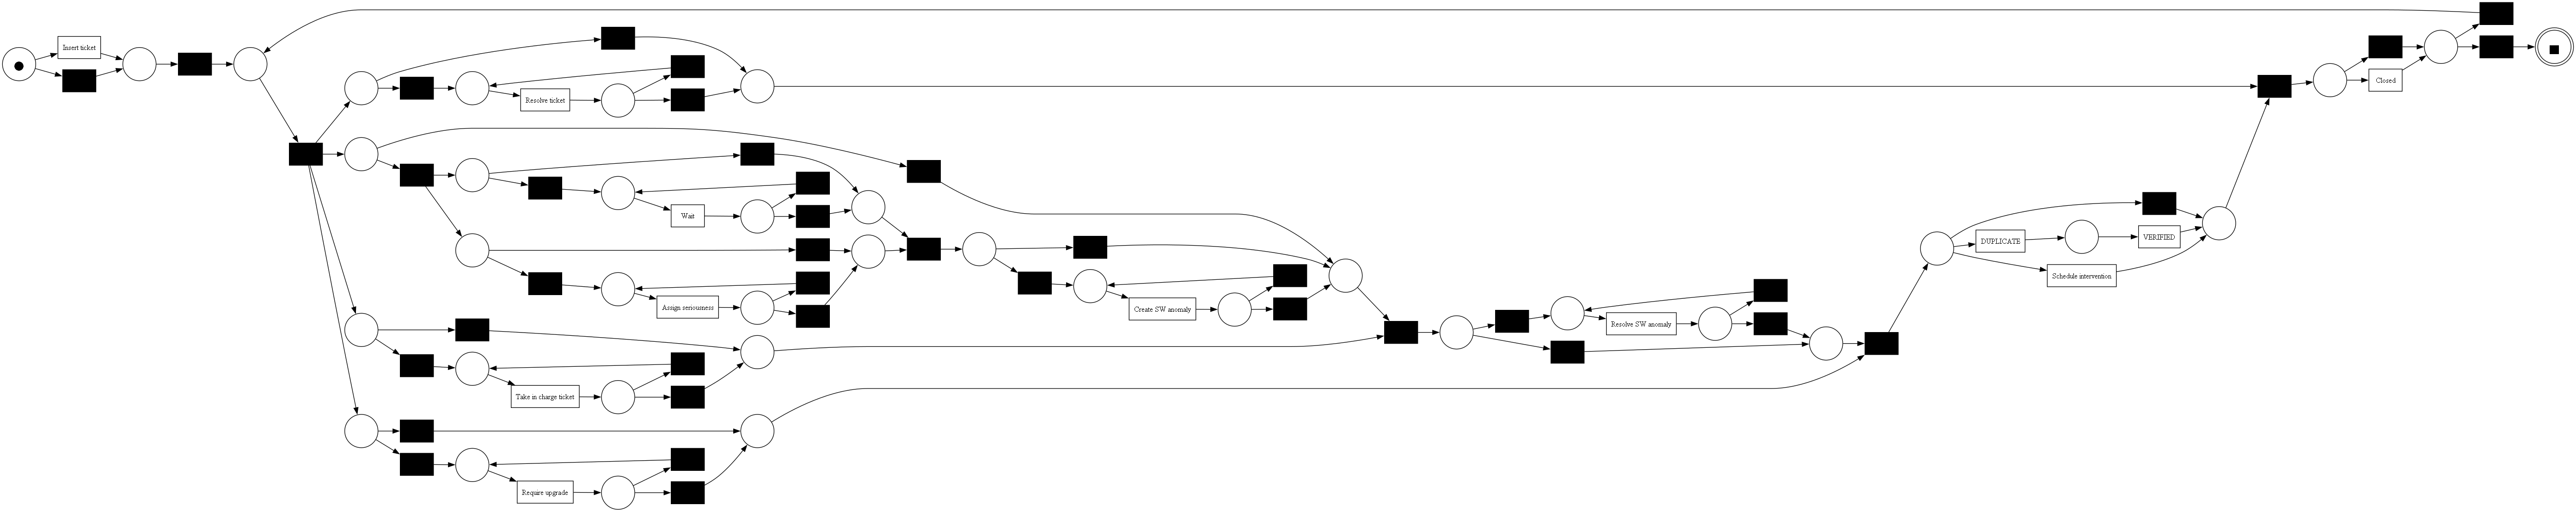

replaying log with TBR, completed traces :: 100%|██████████| 2/2 [00:00<00:00, 249.25it/s]

Time : {'Average time': 13.439, 'Standard deviation time': 6.879} 	
Jaccard similarity : {'Activities': 0.833, 'Resources': 0.667} 	
Damerau-Levenshtien similarity : {'Activities': 0.889, 'Resources': 0.722} 	
Compliance : 1.0 	
Fitness : 1.0 	


In [24]:
from NeSy4PPM.Evaluation import evaluate_all, discover_petri_net

# discover a petri nets model from test log:
petri_net_model = discover_petri_net(log_path/test_log)

metrics = ["Time", "Jaccard similarity", "Damerau-Levenshtien similarity", "Compliance", "Fitness"]
prediction_filename = 'helpdesk_case1327_prediction.csv'

metrics_results = evaluate_all(log_data=log_data, model_arch=model_arch, encoder=encoder, output_folder=output_folder,
                               filename=prediction_filename, metrics=metrics, resource=resource, declare_model=bk_model,petri_net_model=petri_net_model, fitness_method="fitness_token_based_replay")
for metric in metrics:
    print(metric,":",metrics_results[metric],"\t")